## Predicting Fragrance Bestsellers

### Approach

Reviews and loves for each fragrance both appear to be highly correlated with bestsellers (as we might've guessed). However, this information would not be available before advertising the product for sale. Instead, we will use information that we would have access to before selling the fragrances to see if we can predict bestselling fragrances. 

### Results

Our model achieved an accuracy of 0.865, precision of .47, and recall of .33.

While our precision and recall might be lower than we'd like we've been able to predict a fair number of bestsellers, which could be useful when deciding which products to carry or promote.

In order to decide how successful our model is, we would need to know the cost of incorrectly predicting a bestseller (cost of advertising, shelf space, etc) and the likely profit for correctly predicting bestsellers.

In the case that advertising is driving the majority of bestsellers, we are predicting which fragrances Sephora will promote. This information might be useful competitors or those interesting in opening a new fragrance line.

### Possible Improvements

- increasing the number of observations by collecting fragrance data over time
    - cross-validation instead of balancing classes once more data has been collected 
- improving color clustering (L*a*b* color space, Minkowski) 
- imputing missing data via unsupervised learning (kmeans)
- using NLP to determine fragrance types

In [475]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#load cleaned data
df_details = pd.read_csv('~/perfume_proj/data/processed/fragrance_details.csv')

pd.options.mode.chained_assignment = None

#df for model data
df_model = pd.DataFrame()

## Feature Engineering

In [476]:
from sklearn.cluster import KMeans

#add price per oz feature
df_details['price_per_oz'] = df_details.price/df_details.oz_at_price

#create other categories for brand and type 
df_details.loc[df_details['type'].isin(
    (df_details['type'].value_counts()[df_details['type'].value_counts()<=20]).index), 'type'] = 'other_type'

#add color clusters
kmeans = KMeans(n_clusters =50).fit(dominant_colors)
df_details['color_cluster'] = kmeans.labels_

### Handling Missing Values

In [477]:
scent_descriptors = ['floral', 'fresh ', 'warm', 'spicy|spice', 'earthy', 'woody|wood', 
                     'musk|musky', 'vanilla', 'fruit|fruity', 'sweet', 'oil', 'rose']

#build model df
df_model['advertised_price'] = df_details.price
df_model['advertised_oz'] = df_details.oz_at_price
df_model['bestseller'] = df_details.bestseller.apply(lambda x: 1 if x is True else 0)
df_model['price_per_oz'] = df_details.price_per_oz
df_model[scent_descriptors] = df_details[scent_descriptors]


#fill missing advertised_oz with median 
df_model.advertised_oz[df_model.advertised_oz.isna()]= df_model.advertised_oz.median()

#fill missing options with standard size
df_details.options[df_details.options.isna()] = "['standard size']"

### Create Dummies 

In [478]:
size_opt_dummies = df_details.options.str.replace(r"[^a-zA-Z0-9_,]", '').str.get_dummies(sep=',')
type_dummies = pd.get_dummies(df_details.type)
brand_dummies = pd.get_dummies(df_details.brand)
gender_dummies = pd.get_dummies(df_details.sex, drop_first = True)
color_dummies = pd.get_dummies(df_details.color_cluster)

df_model = pd.concat([df_model, size_opt_dummies], axis=1)
df_model = pd.concat([type_dummies, df_model], axis =1)
df_model = pd.concat([brand_dummies, df_model], axis =1)
df_model = pd.concat([gender_dummies, df_model], axis =1)
df_model = pd.concat([color_dummies, df_model], axis =1)

In [479]:
df_model.head()

,0,1,2,3,4,5,6,7,8,9,...,vanilla,fruit|fruity,sweet,oil,rose,jumbosize,minisize,sale,standardsize,valuesize
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0


## Classifier

In [569]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

df_model = df_model.dropna()

X = df_model.drop('bestseller', axis =1)
y = df_model.bestseller

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .15, shuffle = True, random_state=12)

#oversample to balance imbalanced classes
sm = SMOTE(random_state=12, sampling_strategy = .6)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


From earlier EDA we saw that our dataset is imbalanced, therefore we oversample to correct for this imbalance. Undersampling would leave us with too little data to build our model with. We also split our data 85% training and 15% so that the model has more data to learn from.

Accuracy:  0.8653846153846154


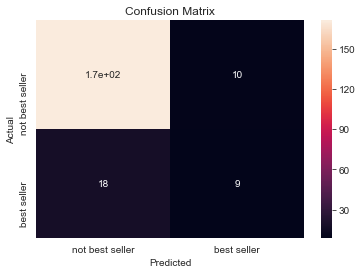

In [585]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

boost = GradientBoostingClassifier(max_depth=5 , n_estimators= 450)

boost.fit(X_train_res, y_train_res)
y_predict = boost.predict(X_test)

#plot confusion matrix
cm = confusion_matrix(y_test, y_predict)   
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not best seller', 'best seller'])
ax.yaxis.set_ticklabels(['not best seller','best seller'])

print('Accuracy: ', boost.score(X_test, y_test))

In [587]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test,y_predict)
recall = recall_score(y_test, y_predict)

precision, recall

(0.47368421052631576, 0.3333333333333333)

In [575]:
feature_importances = sorted(list(zip(boost.feature_importances_, X.columns)), key = lambda x: x[0], reverse = True)

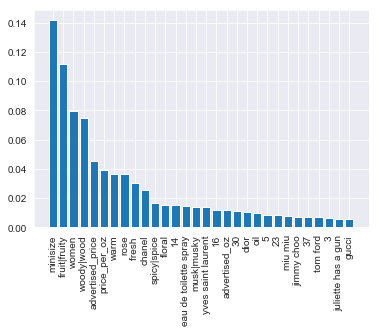

In [576]:
sns.set_style('darkgrid')
y, x = zip(*feature_importances)
plt.bar([str(i) for i in x][:30], y[:30])
plt.xticks(rotation=90);